# Make scvi representation of cells

In [1]:
slide_id = "skin_s4"

-----
-----

In [2]:
# Using sopa environment
import spatialdata as sd
sdata = sd.read_zarr(f"/Volumes/DD_FGS/MICS/data_HE2CellType/CT_DS/sdata_processed/sdata_{slide_id}.zarr", selection=('tables',))
sdata

/Users/felicie-giraud-sauveur/miniforge3/envs/sopa/lib/python3.10/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/Users/felicie-giraud-sauveur/miniforge3/envs/sopa/lib/python3.10/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'nucleus_boundaries', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


SpatialData object, with associated Zarr store: /Volumes/DD_FGS/MICS/data_HE2CellType/CT_DS/sdata_processed/sdata_skin_s4.zarr
└── Tables
      ├── 'table_cells': AnnData (109795, 5006)
      └── 'table_nuclei': AnnData (109795, 7638)
with coordinate systems:

with the following elements in the Zarr store but not in the SpatialData object:
    ▸ nucleus_boundaries (Shapes)
    ▸ morpho (Images)
    ▸ cell_boundaries (Shapes)
    ▸ he (Images)
    ▸ st (Points)

In [3]:
# Only cells with more than 10 transcrits
adata_scvi_ini = sdata.tables['table_cells'].copy()
adata_scvi = adata_scvi_ini[adata_scvi_ini.obs['transcript_counts'] > 10].copy()
adata_scvi

AnnData object with n_obs × n_vars = 106783 × 5006
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

In [4]:
adata_scvi.write_h5ad(f"/Volumes/DD_FGS/MICS/data_HE2CellType/CT_DS/adata_scvi/adata_scvi_{slide_id}.h5ad")

------
------

## Model training and latent representation

In [2]:
# Using scvi environment
import scanpy as sc
import scvi
import seaborn as sns
import torch
from tqdm.notebook import tqdm
import os
import matplotlib.pyplot as plt

/Users/felicie-giraud-sauveur/miniforge3/envs/scvi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
scvi.settings.seed = 0
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

Seed set to 0


In [4]:
# Apply get_scvi_models_ruche.py

In [5]:
adata_scvi = sc.read_h5ad(f"/Volumes/DD_FGS/MICS/data_HE2CellType/CT_DS/adata_scvi_output/adata_scvi_{slide_id}.h5ad")
model = scvi.model.SCVI.load(os.path.join(f"/Volumes/DD_FGS/MICS/data_HE2CellType/CT_DS/models_scvi/scvi_model_{slide_id}"), adata=adata_scvi)

INFO     File /Volumes/DD_FGS/MICS/data_HE2CellType/CT_DS/models_scvi/scvi_model_skin_s4/model.pt already          
         downloaded                                                                                                


/Users/felicie-giraud-sauveur/miniforge3/envs/scvi/lib/python3.12/site-packages/scvi/model/base/_save_load.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch

In [6]:
model.history.keys()

dict_keys(['lr-AdamW', 'kl_weight', 'train_loss_step', 'validation_loss', 'elbo_validation', 'reconstruction_loss_validation', 'kl_local_validation', 'kl_global_validation', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train'])

<Axes: xlabel='step'>

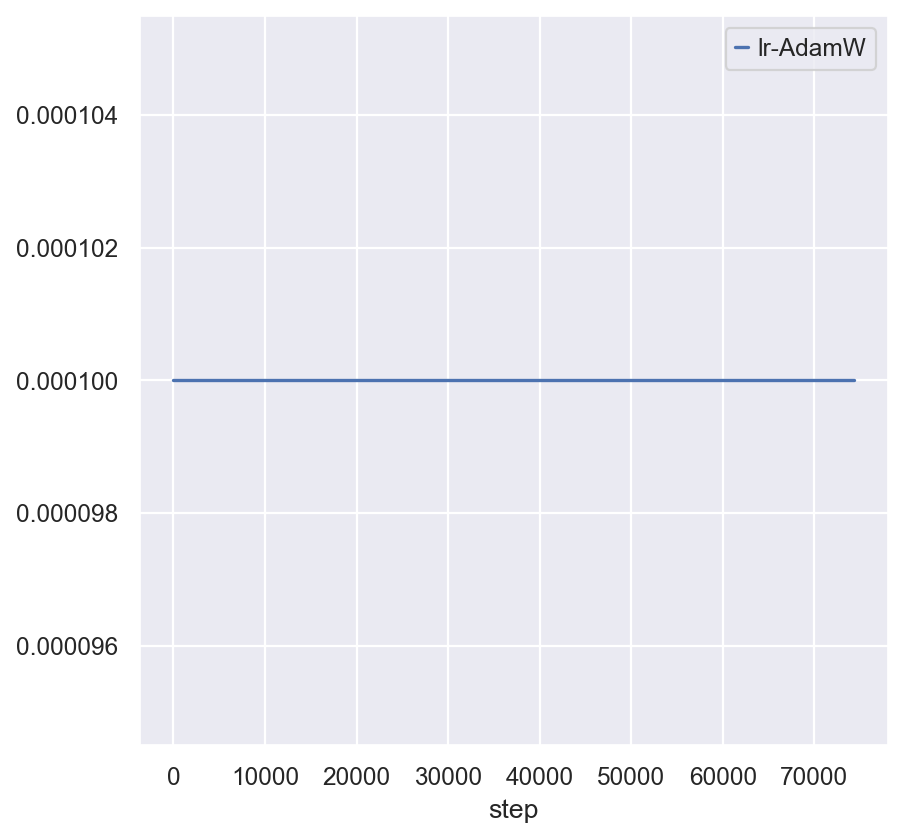

In [7]:
model.history["lr-AdamW"].plot()

- **Training Loss**: 
    - The loss function tells you how well your model is doing during training. As the model trains, the loss should decrease over time. In an SCVI model, the loss is a combination of two things: Reconstruction loss (measures how well the model can reconstruct the original data) + KL divergence (ensures that the latent variables are regularized and don’t overfit).
    - Ensure that the loss is steadily decreasing over time. This indicates that the model is learning. If the loss isn’t decreasing, it might mean that the model isn’t learning well. You want to see a smooth decline. Some fluctuations are normal, but if the loss stops decreasing too early or starts increasing, it could be a sign of overfitting or a learning issue.
    - If training loss increase after a certain time: With higher learning rates you are moving too much in the direction opposite to the gradient and may move away from the local minima which can increase the loss. 
- **Training vs Validation Loss**:
    - You should see both losses decrease together. If the validation loss starts increasing while the training loss continues decreasing, this is a sign of overfitting. The training and validation losses should ideally decrease together. If validation loss starts to increase while training loss keeps dropping, consider stopping the training (this is where early stopping can help).
- **ELBO (Evidence Lower Bound)** /  elbo_train vs elbo_validation:
    - The ELBO is the key metric for evaluating a VAE model (like SCVI). It combines both reconstruction and KL divergence losses. The lower the ELBO, the better your model is at capturing the underlying data structure while regularizing the latent space.
    - Both elbo_train and elbo_validation should decrease. The gap between the two shouldn’t be too large. If the gap grows, it’s an indication that the model is overfitting to the training data.
- **Reconstruction Loss** / reconstruction_loss_train vs reconstruction_loss_validation:
    - This loss measures how well your model can reconstruct the original data. It’s an essential part of the overall ELBO. A good reconstruction loss means the model is learning the structure of the data correctly.
    - Both losses should steadily decrease. If the validation reconstruction loss starts increasing while the training one continues to decrease, it’s a sign of overfitting.
- **Local KL Divergence** (Regularization) / KL Divergence Metrics (kl_local_train, kl_global_train, etc.):
    - The KL divergence regularizes the latent space by ensuring the learned distribution doesn’t stray too far from a prior distribution (a normal distribution). You want the KL divergence to gradually decrease, but not too much. If the KL divergence is too small, it might mean your model isn’t learning useful latent features.
    - The KL divergence values should decrease steadily but should not approach zero. A KL divergence that is too low might mean that the latent space isn’t being regularized enough, and the model could be overfitting to the data.
- **Global vs Local KL Divergence**:
    - The local KL divergence applies to individual cells. This regularization helps the model generalize better by preventing overfitting to each individual cell’s data. Without this regularization, the model might overfit and learn latent variables that capture noise rather than meaningful biological patterns.
    - The global KL divergence regularizes the shared latent space for all cells. This applies when there are global latent variables (i.e., variables that are the same across all cells, representing shared information). Global KL regularization ensures that the shared structure between cells is meaningful and doesn’t overfit to spurious relationships. It enforces that the global latent variables remain close to a prior, much like the local KL does for individual cells.
    - The combination of local and global KL divergence keeps both cell-level and shared latent structures from diverging too far from a reasonable prior (usually a standard normal distribution).
    - If the local KL divergence becomes too small, the model might not be regularizing enough, meaning it could be overfitting to individual cells. Global KL should also decrease but usually at a slower rate, since global latent variables represent more abstract or shared structures. If the global KL divergence is too low, the shared latent structure across cells may not be regularized enough, and it could overfit to batch effects or other confounding factors.

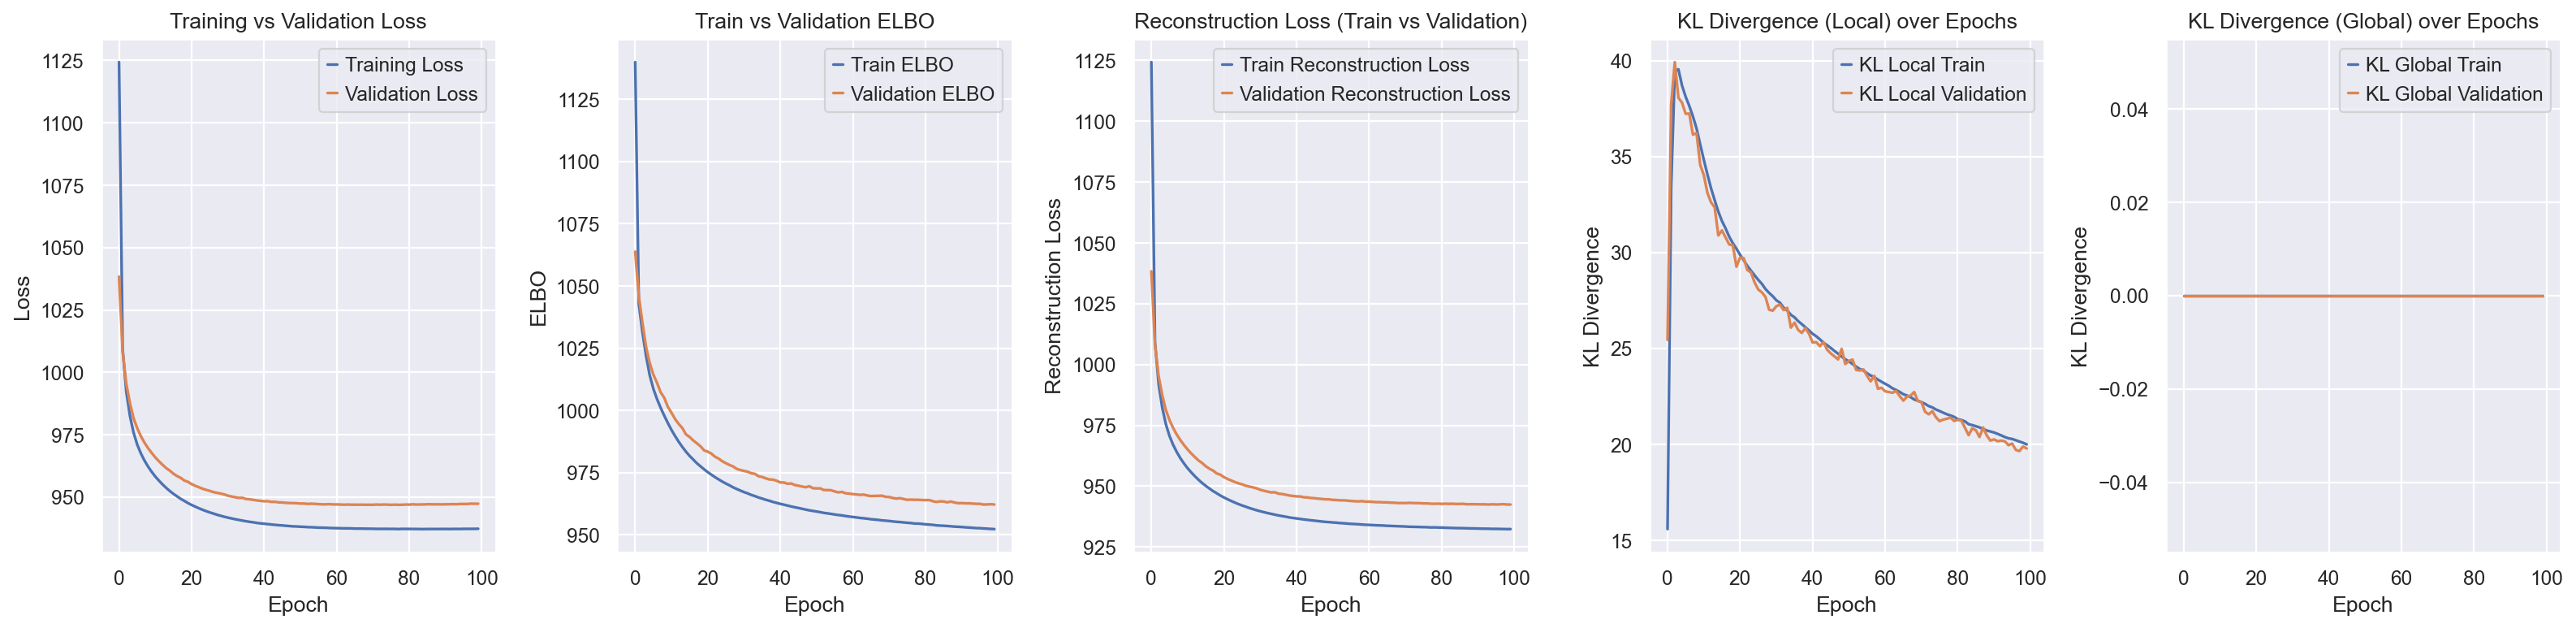

In [8]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

# Plot Training vs Validation Loss
axs[0].plot(model.history['train_loss_epoch'], label='Training Loss')
axs[0].plot(model.history['validation_loss'], label='Validation Loss')
axs[0].set_title('Training vs Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot Train vs Validation ELBO
axs[1].plot(model.history['elbo_train'], label='Train ELBO')
axs[1].plot(model.history['elbo_validation'], label='Validation ELBO')
axs[1].set_title('Train vs Validation ELBO')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('ELBO')
axs[1].legend()

# Plot Reconstruction Loss (Train vs Validation)
axs[2].plot(model.history['reconstruction_loss_train'], label='Train Reconstruction Loss')
axs[2].plot(model.history['reconstruction_loss_validation'], label='Validation Reconstruction Loss')
axs[2].set_title('Reconstruction Loss (Train vs Validation)')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Reconstruction Loss')
axs[2].legend()

# Plot KL Divergence (Local) over Epochs
axs[3].plot(model.history['kl_local_train'], label='KL Local Train')
axs[3].plot(model.history['kl_local_validation'], label='KL Local Validation')
axs[3].set_title('KL Divergence (Local) over Epochs')
axs[3].set_xlabel('Epoch')
axs[3].set_ylabel('KL Divergence')
axs[3].legend()

# Plot KL Divergence (Global) over Epochs
axs[4].plot(model.history['kl_global_train'], label='KL Global Train')
axs[4].plot(model.history['kl_global_validation'], label='KL Global Validation')
axs[4].set_title('KL Divergence (Global) over Epochs')
axs[4].set_xlabel('Epoch')
axs[4].set_ylabel('KL Divergence')
axs[4].legend()

plt.tight_layout()
plt.show()

In [9]:
latent = model.get_latent_representation()
adata_scvi.obsm["X_scVI"] = latent
latent.shape

(106783, 10)

In [10]:
sc.pp.neighbors(adata_scvi, use_rep="X_scVI")
sc.tl.umap(adata_scvi, min_dist=0.3)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [11]:
adata_cells = sc.read_h5ad(f"/Volumes/DD_FGS/MICS/data_HE2CellType/CT_DS/adata_annots_cells/adata_annots_cells_{slide_id}.h5ad")
adata_cells

AnnData object with n_obs × n_vars = 106783 × 5006
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'pca_n10_pcs16_leiden_res0.2', 'pca_n10_pcs16_leiden_res0.4', 'pca_n10_pcs16_leiden_res0.6', 'refine_res', 'label1', 'label2', 'label3'
    var: 'gene_ids', 'feature_types', 'genome', 'mean', 'std'
    uns: 'label1_colors', 'label2_colors', 'label3_colors', 'log1p', 'pca', 'pca_n10_pcs16', 'pca_n10_pcs16_leiden_res0.2', 'pca_n10_pcs16_leiden_res0.2_colors', 'pca_n10_pcs16_leiden_res0.4', 'pca_n10_pcs16_leiden_res0.4_colors', 'pca_n10_pcs16_leiden_res0.6', 'pca_n10_pcs16_leiden_res0.6_colors', 'rank_genes_refine_res', 'refine_res_colors', 'spatialdata_attrs', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'count', 'log_norm'
    ob

In [12]:
cellid2label1 = dict(adata_cells.obs[['cell_id', 'label1']].values)
adata_scvi.obs['label1'] = adata_scvi.obs['cell_id'].map(cellid2label1)

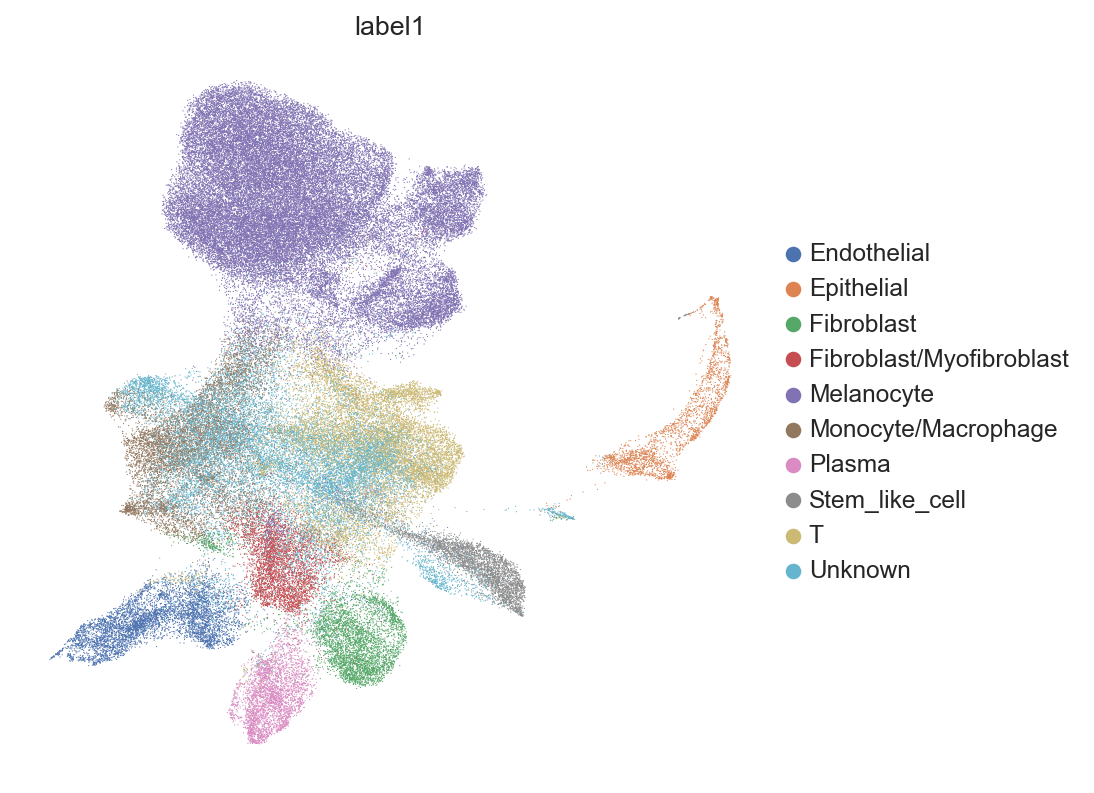

In [13]:
sc.pl.umap(adata_scvi, color='label1')

In [14]:
adata_scvi.write_h5ad(f"/Volumes/DD_FGS/MICS/data_HE2CellType/CT_DS/adata_scvi/adata_scvi_{slide_id}.h5ad")